In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from torchvision.transforms import functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from vit_pytorch.deepvit import DeepViT
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os
import random
import warnings
warnings.filterwarnings(action='ignore')

/storage/home/ndh5286/.local/lib/python3.8/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


# Check for GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import Images and Plot

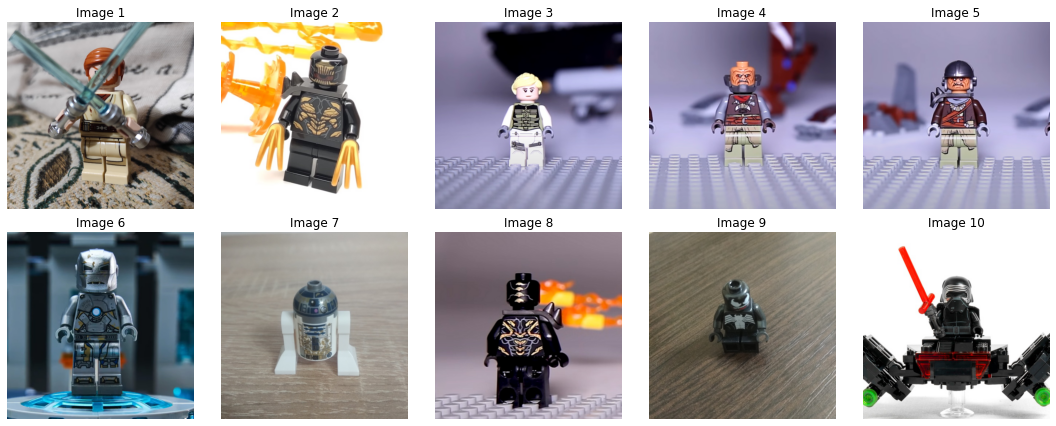

In [4]:
def process_images(directory):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith(('.jpg', '.jpeg')):
                image_path = os.path.join(root, filename)
                image_paths.append(image_path)
    return image_paths

def plot_random_images(directory):
    image_paths = process_images(directory)
    
    if len(image_paths) == 0:
        print("No images found in the directory.")
        return
    
    num_images = min(10, len(image_paths))
    random_images = random.sample(image_paths, num_images)
    
    rows = (num_images + 4) // 5  # Calculate number of rows needed
    fig, axes = plt.subplots(rows, 5, figsize=(15, 3 * rows))
    axes = axes.flatten()

    for i, image_path in enumerate(random_images):
        img = Image.open(image_path)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i + 1}")
        axes[i].axis('off')
    
    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

image_directory = "train"
plot_random_images(image_directory)

# Plot Images with Object Detection

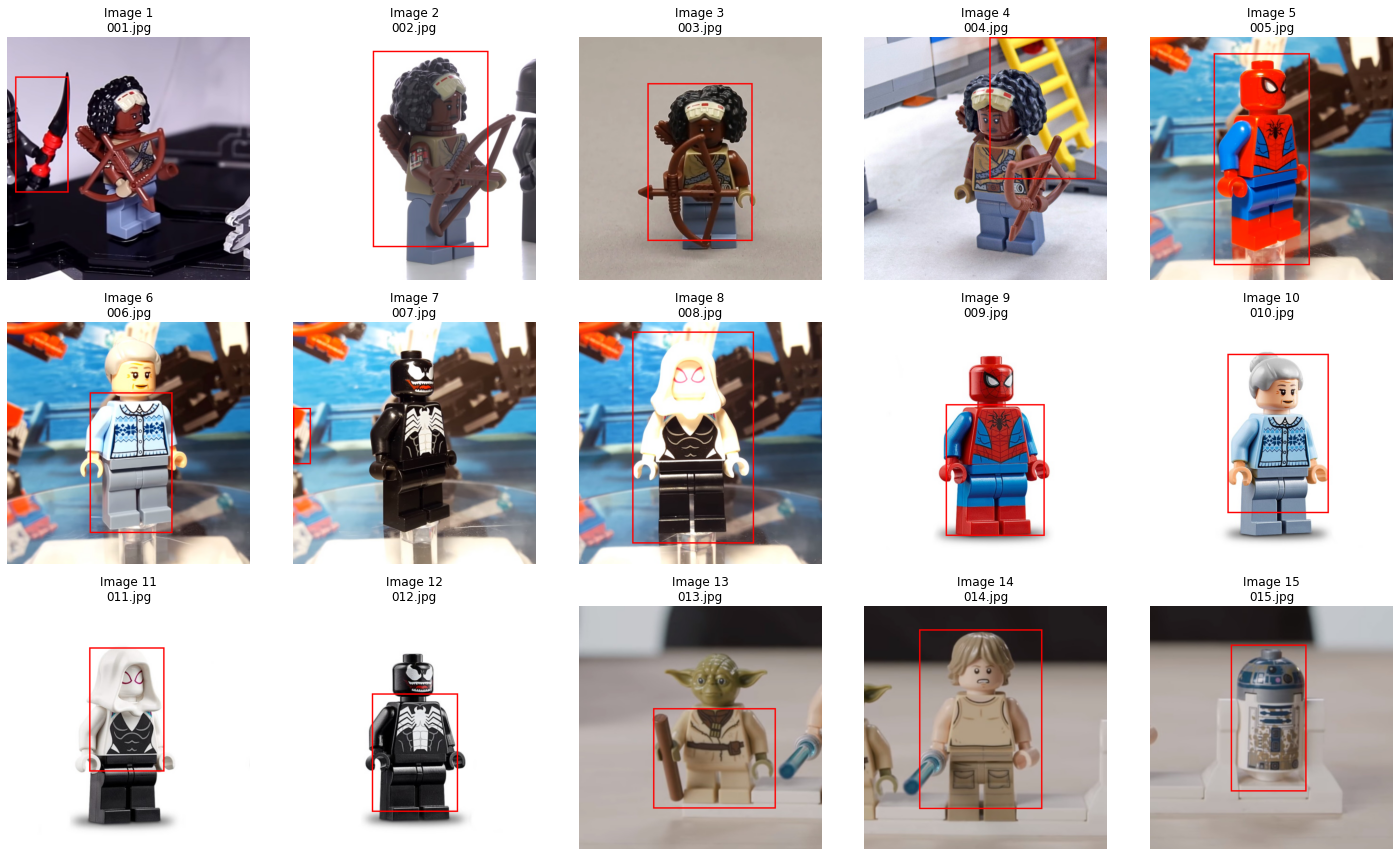

In [5]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)
model.to(device)
model.eval()

def detect_objects(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        prediction = model(image_tensor)
    
    boxes = prediction[0]['boxes'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    
    # Select only the highest confidence detection
    if len(scores) > 0:
        best_index = scores.argmax()
        boxes = boxes[best_index:best_index+1]
        scores = scores[best_index:best_index+1]
    else:
        boxes = np.array([])
        scores = np.array([])
    
    return image, boxes, scores



def plot_images_with_detection(process_images, num_images=15):
    images_with_detections = []
    
    for i, image_path in enumerate(process_images):
        if i >= num_images:
            break
        
        image, boxes, scores = detect_objects(image_path)
        
        # Draw bounding box and label on the image
        draw = ImageDraw.Draw(image)
        for box, score in zip(boxes, scores):
            draw.rectangle(box.tolist(), outline='red', width=3)
        
        images_with_detections.append((image, image_path))
    
    # Plot the images
    rows = (len(images_with_detections) + 4) // 5  # Calculate number of rows needed
    fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows))
    axes = axes.flatten()

    for i, (image, image_path) in enumerate(images_with_detections):
        axes[i].imshow(image)
        axes[i].set_title(f"Image {i + 1}\n{os.path.basename(image_path)}")
        axes[i].axis('off')
    
    # Turn off any unused subplots
    for j in range(len(images_with_detections), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Call
image_directory = "test"
plot_images_with_detection(process_images(image_directory))

# Classify Minifigures

### 1. Create Image Tensors

In [6]:
image_directory = "train"
index = pd.read_csv("index.csv")

# Initialize empty lists to store images and labels
images = []
processed_labels = []

# Define a transform to convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images to a consistent size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Process images and labels
for _, row in index.iterrows():
    file_path = row['path']
    label = row['class_id']
    
    full_path = os.path.join(image_directory, file_path)
    
    if os.path.exists(full_path):
        # Convert image to tensor and add to list
        image = Image.open(full_path).convert('RGB')
        img_tensor = transform(image)
        images.append(img_tensor)
        
        # Add corresponding label
        processed_labels.append(label)
    else:
        print(f"Warning: Image file not found: {full_path}")

print(f"Processed {len(images)} images and {len(processed_labels)} labels.")

images_tensor = torch.stack(images).to(device)

Processed 371 images and 371 labels.


### 2. Onehot Encode Labels

In [7]:
# function to get unique values
def unique(list1):
    unique_list = pd.Series(list1).drop_duplicates().tolist()
    return len(unique_list)

# Convert labels to one-hot encoding if necessary
num_classes = unique(processed_labels)

if num_classes > 1:
    # One-hot encoding using get_dummies
    df_onehot = pd.get_dummies(processed_labels)

df_onehot = df_onehot.to_numpy()
df_onehot = torch.tensor(df_onehot, dtype=torch.float32)

### 3. Train ViT Model

In [20]:
# Create dataset and dataloader
dataset = TensorDataset(images_tensor, df_onehot)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the DeepViT model
model = DeepViT(
    image_size = 512,
    patch_size = 32,
    num_classes = num_classes,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = .2
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() if num_classes > 1 else nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training loop
num_epochs = 65
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_images, batch_labels in dataloader:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training completed!")

Epoch [1/65], Loss: 3.5259
Epoch [2/65], Loss: 3.2693
Epoch [3/65], Loss: 3.2034
Epoch [4/65], Loss: 3.1809
Epoch [5/65], Loss: 3.1015
Epoch [6/65], Loss: 3.0468
Epoch [7/65], Loss: 3.0517
Epoch [8/65], Loss: 2.9970
Epoch [9/65], Loss: 2.9187
Epoch [10/65], Loss: 2.8569
Epoch [11/65], Loss: 2.7957
Epoch [12/65], Loss: 2.8118
Epoch [13/65], Loss: 2.7584
Epoch [14/65], Loss: 2.6763
Epoch [15/65], Loss: 2.5808
Epoch [16/65], Loss: 2.5728
Epoch [17/65], Loss: 2.4334
Epoch [18/65], Loss: 2.3924
Epoch [19/65], Loss: 2.3011
Epoch [20/65], Loss: 2.2659
Epoch [21/65], Loss: 2.1882
Epoch [22/65], Loss: 2.1803
Epoch [23/65], Loss: 2.1172
Epoch [24/65], Loss: 1.9516
Epoch [25/65], Loss: 1.8965
Epoch [26/65], Loss: 1.8131
Epoch [27/65], Loss: 1.7273
Epoch [28/65], Loss: 1.6867
Epoch [29/65], Loss: 1.6492
Epoch [30/65], Loss: 1.5336
Epoch [31/65], Loss: 1.4213
Epoch [32/65], Loss: 1.4140
Epoch [33/65], Loss: 1.3161
Epoch [34/65], Loss: 1.2821
Epoch [35/65], Loss: 1.1640
Epoch [36/65], Loss: 1.1567
E

### 4. Evalute on Test Data

In [26]:
import torch.nn.functional as F

image_directory = "test"
test = pd.read_csv("test.csv")

# Initialize counters for accuracy calculation
correct_predictions = 0
total_samples = 0

model.eval()

for _, row in test.iterrows():
    file_path = row['path']
    image = transform(Image.open(file_path).convert('RGB'))
    # Add a batch dimension
    image = image.unsqueeze(0).to(device)
    label = row['class_id']
    
    # Get model predictions
    with torch.no_grad():  # Disable gradient calculation for inference
        output = model(image)
     
    # Get the predicted label (the class with the highest probability)
    pred_label = output.argmax(dim=1).item()
    
    # Check if the prediction is correct
    if pred_label == label:
        correct_predictions += 1
    total_samples += 1

# Compute accuracy
accuracy = correct_predictions / total_samples if total_samples > 0 else 0
print(f'Accuracy: {accuracy}')   

Accuracy: 0.0379746835443038
